## Imports....

In [208]:
import matplotlib.pyplot as plt
import numpy as np
import random

%env CUDA_VISIBLE_DEVICES=0
import torch
import torchvision as tv
from torchvision import datasets, transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import math

import time
import wavio

env: CUDA_VISIBLE_DEVICES=0


## Hyperparameters

In [209]:
#set up hyperparameters, net input/output sizes, and whether the problem is compressed sensing

LR = 1e-4 # learning rate
MOM = 0.9 # momentum
NUM_ITER = 5000 # number iterations
WD = 1e-4 # weight decay for l2-regularization

Z_NUM = 32 # input seed
NGF = 64 # number of filters per layer
BATCH_SIZE = 1 # batch size of gradient step
nc = 1 #num channels in the net I/0

#choose the number of samples and periods in the training waveform
WAVE_LEN = 16384
WAVE_RATE = 8192
WAVE_RES = 1 #bytes per sample

In [210]:
compressed = True
compressed_noisy = False

if compressed:
    num_measurements = 100
else:
    num_measurements = WAVE_LEN
    
normalised = True
scaled = not normalised

In [211]:
CUDA = torch.cuda.is_available()
print("On GPU: ", CUDA)

#save the correct datatype depending on CPU or GPU execution
if CUDA : 
    dtype = torch.cuda.FloatTensor  
else:
    dtype = torch.FloatTensor

On GPU:  True


## Grab the training audio wave and set Net Hyperparams

In [212]:
wave = wavio.read("audio_data/chirp_8192hz_2s.wav")
WAVE_RATE = wave.rate
WAVE_LEN = wave.data.shape[0]
WAVE_RES = wave.sampwidth
nc = wave.data.shape[1]
y0 = wave.data

print("Sampling Rate: ", WAVE_RATE)
print("Num Samples: ", WAVE_LEN)
print("Clip Length: ", round(WAVE_LEN/(1.0*WAVE_RATE), 2))
print("Bits/Sample: ", 8*WAVE_RES)
print("Num Channels: ", nc)

Sampling Rate:  8192
Num Samples:  16384
Clip Length:  2.0
Bits/Sample:  16
Num Channels:  1


## Define Wave Normalisation

In [213]:
#ugly solution for maintaining wave's original stats 
def get_stats(x):
    chans = x.shape[1]
    
    maxes = np.zeros((chans))
    mins = np.zeros((chans))
    mu = np.zeros((chans))
    sigma = np.zeros((chans))
    power = np.zeros((chans), dtype = float)
    
    for c in range(chans):
        mu[c] = np.mean(x[:,c])
        sigma[c] = np.std(x[:,c])
        maxes[c] = np.max(x[:,c])
        mins[c] = np.min(x[:,c])
        power[c] = np.mean(np.array(x[:,c], dtype = float)**2)
    
    return [mu, sigma, mins, maxes, power]

MU, SIGMA, MINS, MAXES, POWER = get_stats(y0)

#Transforms distribution of signal amplitudes to be Gaussian(0,1)
def normalise(x, mean, std):
    normalised = np.zeros((x.shape))
    chans = x.shape[1]
    
    for c in range(chans):
        normalised[:,c] = (x[:,c] - mean[c])/std[c]
        
    return normalised

#Transforms distribution of signal amplitudes from Gaussian(0,1) back to original 
def renormalise(x, mean, std):
    renormalised = np.zeros((x.shape))
    chans = x.shape[1]
    
    for c in range(chans):
        renormalised[:,c] = (x[:,c] * std[c]) + mean[c]
        
    return renormalised

#linearly scales a signal's range: [a, b] --> [-1, 1]
def scale(x, mins, maxes):
    chans = x.shape[1]
    scaled = np.zeros((x.shape))
    
    for c in range(chans):
        translate = (mins[c] + maxes[c])/2.0
        scale = (maxes[c] - mins[c])/2.0
        
        scaled[:,c] = (x[:,c] - translate)/scale 
    
    return scaled
        
#linearly scales a signal's range: [-1, 1] --> [a, b]
def rescale(x, mins, maxes):
    chans = x.shape[1]
    rescaled = np.zeros((x.shape))
    
    for c in range(chans):
        translate = (mins[c] + maxes[c])/2.0
        scale = (maxes[c] - mins[c])/2.0
        
        rescaled[:,c] = (x[:,c] * scale) + translate
    
    return rescaled

print("Means: ", MU)
print("STD: ", SIGMA)
print("Mins: ", MINS)
print("Maxes: ", MAXES)
print("POWER: ", POWER)

Means:  [-897.30291748]
STD:  [6353.61919985]
Mins:  [-32768.]
Maxes:  [32767.]
POWER:  [41173629.46246338]


## Prepare Waveform for Training and Define Proper Loss

In [214]:
if scaled:
    y = scale(y0, MINS, MAXES)
else:
    y = normalise(y0, MU, SIGMA)
y = torch.Tensor(y)
y = Variable(y.type(dtype))

mse = torch.nn.MSELoss().type(dtype)

## Net Topology

In [215]:
class DCGAN(nn.Module):
    def __init__(self, nz, ngf=64, output_size=1024, nc=1, num_measurements=64):
        super(DCGAN, self).__init__()
        self.nc = nc
        self.output_size = output_size

        # Deconv Layers: (in_channels, out_channels, kernel_size, stride, padding, bias = false)
        # Inputs: R^(N x Cin x Lin), Outputs: R^(N, Cout, Lout) s.t. Lout = (Lin - 1)*stride - 2*padding + kernel_size

        self.conv1 = nn.ConvTranspose1d(nz, ngf, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm1d(ngf)
        # LAYER 1: input: (random) zϵR^(nzx1), output: x1ϵR^(64x4) (channels x length)

        self.conv2 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn2 = nn.BatchNorm1d(ngf)
        # LAYER 2: input: x1ϵR^(64x4), output: x2ϵR^(64x8) (channels x length)

        self.conv3 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn3 = nn.BatchNorm1d(ngf)
        # LAYER 3: input: x1ϵR^(64x8), output: x2ϵR^(64x16) (channels x length)

        self.conv4 = nn.ConvTranspose1d(ngf,ngf, 6, 2, 2, bias=False)
        self.bn4 = nn.BatchNorm1d(ngf)
        # LAYER 4: input: x1ϵR^(64x16), output: x2ϵR^(64x32) (channels x length)

        self.conv5 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn5 = nn.BatchNorm1d(ngf)
        # LAYER 5: input: x2ϵR^(64x32), output: x3ϵR^(64x64) (channels x length)

        self.conv6 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn6 = nn.BatchNorm1d(ngf)
        # LAYER 6: input: x3ϵR^(64x64), output: x4ϵR^(64x128) (channels x length)

        self.conv7 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn7 = nn.BatchNorm1d(ngf)
        # LAYER 7: input: x4ϵR^(64x128), output: x5ϵR^(64x256) (channels x length)

        self.conv8 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn8 = nn.BatchNorm1d(ngf)
        # LAYER 8: input: x5ϵR^(64x256), output: x6ϵR^(64x512) (channels x length)
        
        self.conv9 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn9 = nn.BatchNorm1d(ngf)
        # LAYER 9: input: x5ϵR^(64x512), output: x6ϵR^(64x1024) (channels x length)
        
        self.conv10 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn10 = nn.BatchNorm1d(ngf)
        # LAYER 10: input: x5ϵR^(64x1024), output: x6ϵR^(64x2048) (channels x length)
        
        self.conv11 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn11 = nn.BatchNorm1d(ngf)
        # LAYER 11: input: x5ϵR^(64x2048), output: x6ϵR^(64x4096) (channels x length)
        
        self.conv12 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn12 = nn.BatchNorm1d(ngf)
        # LAYER 12: input: x5ϵR^(64x4096), output: x6ϵR^(64x8192) (channels x length)

        self.conv13 = nn.ConvTranspose1d(ngf, nc, 4, 2, 1, bias=False)  # output is image
        # LAYER 13: input: x6ϵR^(64x8192), output: (sinusoid) G(z,w)ϵR^(ncx16384) (channels x length)

        self.fc = nn.Linear(output_size * nc, num_measurements, bias=False)  # output is A; measurement matrix
        # each entry should be drawn from a Gaussian (random noisy measurements)
        # don't compute gradient of self.fc! memory issues

    def forward(self, x):
        input_size = x.size()
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = F.relu(self.bn9(self.conv9(x)))
        x = F.relu(self.bn10(self.conv10(x)))
        x = F.relu(self.bn11(self.conv11(x)))
        x = F.relu(self.bn12(self.conv12(x)))
        x = F.tanh(self.conv13(x))

        return x

    def measurements(self, x):
        # this gives the image - make it a single row vector of appropriate length
        y = self.forward(x).view(1, -1)
        y = y.cpu()

        # pass thru FC layer - returns A*image
        meas = self.fc(y)

        if CUDA:
            return meas.cuda()
        else:
            return meas

## Set up Net Parameters

In [216]:
start = time.time()

net = DCGAN(nz = Z_NUM, ngf = NGF, output_size = WAVE_LEN,nc = nc,num_measurements = num_measurements)
net.fc.requires_grad = False

if CUDA: 
    net.cuda()
    
# initialize fully-connected layer weights as our matrix A    
# if compressed, A_tensor: gaussian(0,1) entries in matrix of dim'n R^(num_meas x (wave_size*num_channels)) with normalized columns
# else, A = identity
if compressed:
    if compressed_noisy:
        net.fc.weight.data = (1 / math.sqrt(1.0 * num_measurements)) * torch.randn(num_measurements, WAVE_LEN * nc) #measurement matrix is normalized gaussian R^(num_measurements, wave_size*num_channels)
    else:
        kept_samples = random.sample(range(0, WAVE_LEN*nc), num_measurements) #randomly select num_measurements samples to keep
        net.fc.weight.data = torch.eye(WAVE_LEN*nc)[kept_samples,:] #grab rows corresponding to index of randomly kept samples from identity
else:
    net.fc.weight.data = torch.eye(WAVE_LEN*nc)

allparams = [x for x in net.parameters()] #specifies which to compute gradients of
allparams = allparams[:-1] # get rid of last item in list (fc layer) because it's memory intensive

# Define input seed z as Torch variable, normalize
z = Variable(torch.zeros(BATCH_SIZE*Z_NUM).type(dtype).view(BATCH_SIZE,Z_NUM,1))
z.data.normal_().type(dtype)

# Define optimizer
optim = torch.optim.RMSprop(allparams,lr=LR,momentum=MOM, weight_decay=WD)

end = time.time()
print("Execution Time: ", round(end-start, 4), "s")

Execution Time:  0.2525 s


In [217]:
print(z.shape)
print(y.shape)

torch.Size([1, 32, 1])
torch.Size([16384, 1])


## Prepare Training Waveform for loss during Training

In [218]:
# Create measurements y, move to Torch variable
# torch.mm does matrix multiplication on a flattened row-major version of the image (R^(1)X(H*W*Ch)) and A^T (R^(H*W*Ch)X(measurements)) to produce a R^(measurements vector)
measurements = Variable(torch.mm(y.cpu().data.view(BATCH_SIZE,-1),net.fc.weight.data.permute(1,0)),requires_grad=False) 

if CUDA: # move measurements to GPU if possible
    measurements = measurements.cuda()
    
print(measurements.shape)

torch.Size([1, 100])


## Train Wave while Tracking Loss

0 0.9978852107237822


/home/sravula/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


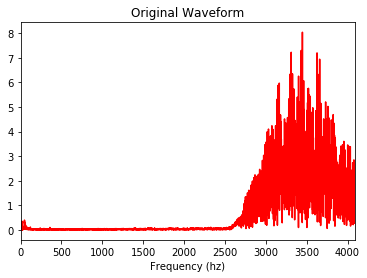

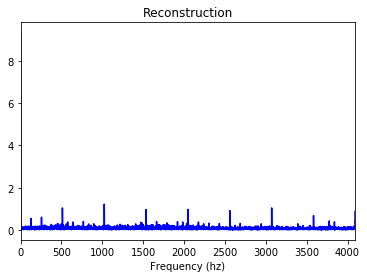

200 1.1305325041869219


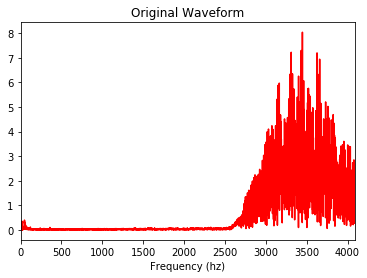

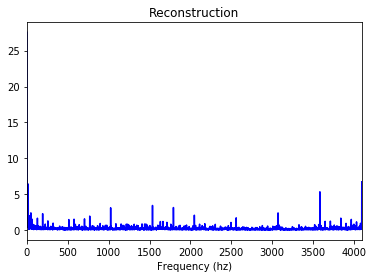

400 1.1076718857764523


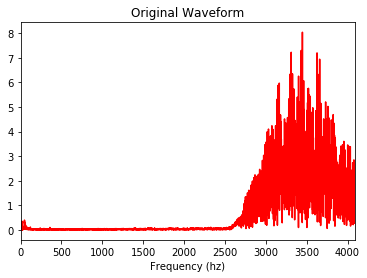

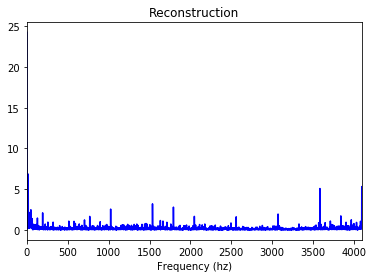

600 1.0752194614452937


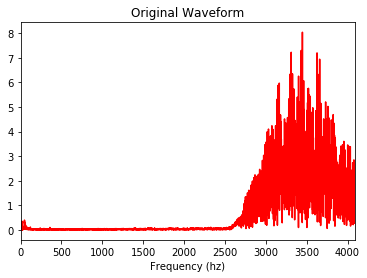

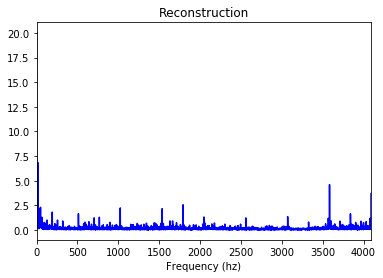

800 1.0461038421945088


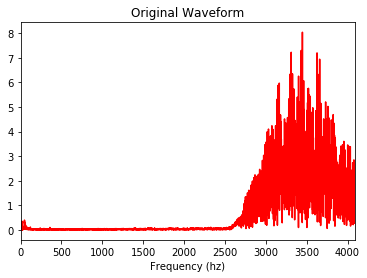

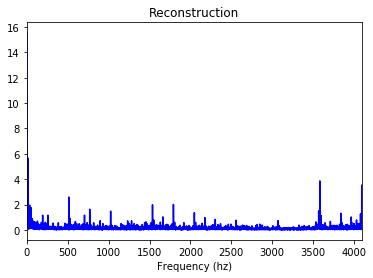

1000 1.0334885686101356


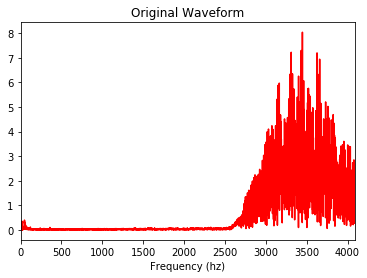

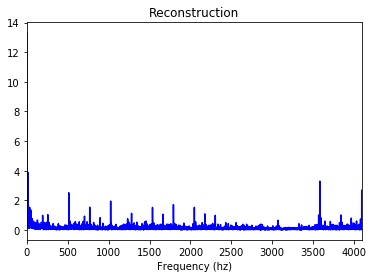

1200 1.0237151976241108


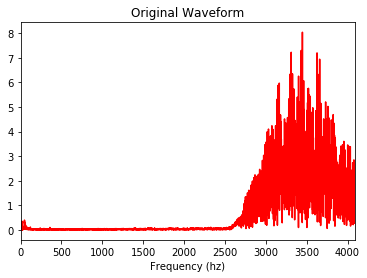

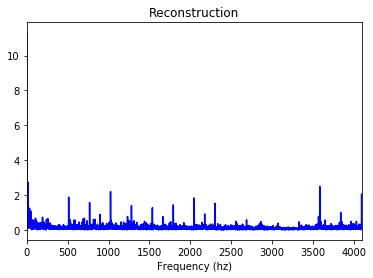

1400 1.0188671033855272


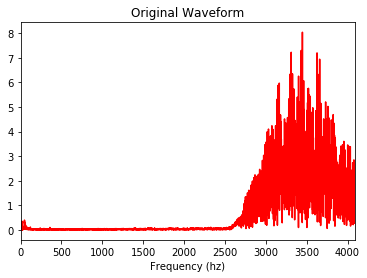

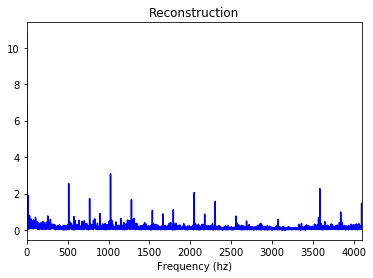

1600 1.0131963410220093


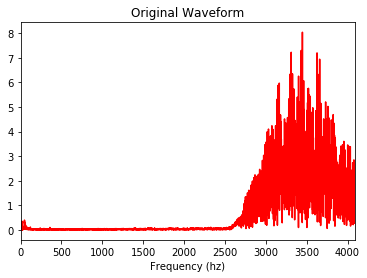

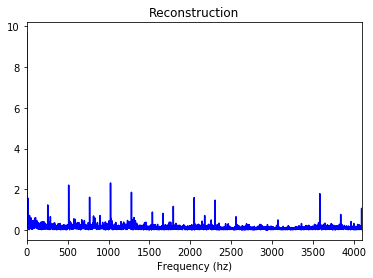

1800 1.005886697549444


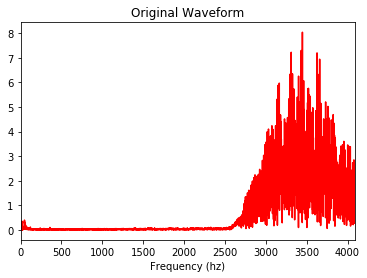

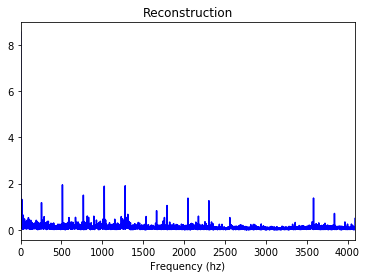

2000 1.0058570653866654


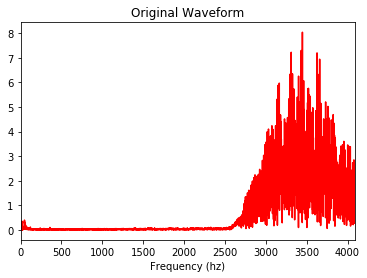

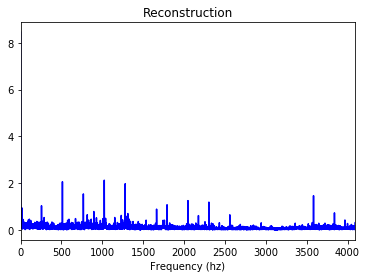

2200 1.007273835545817


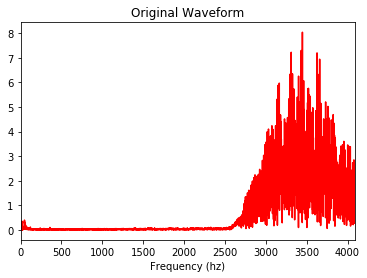

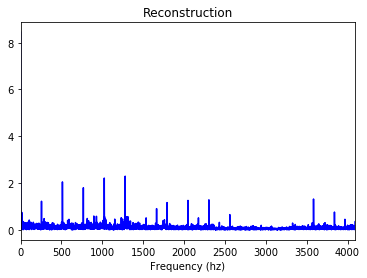

2400 1.0216941402798183


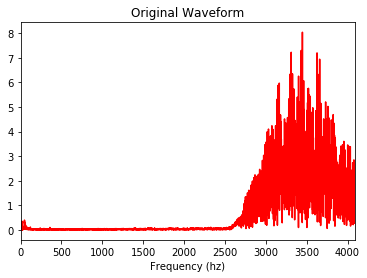

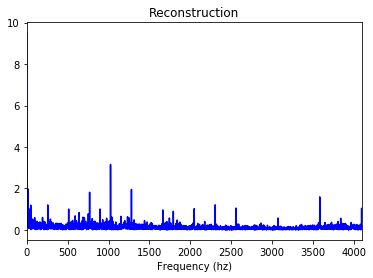

2600 1.012435384347663


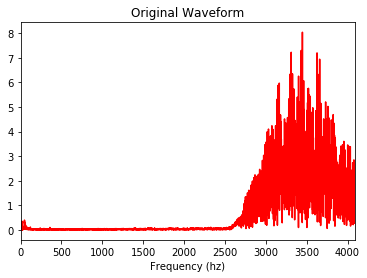

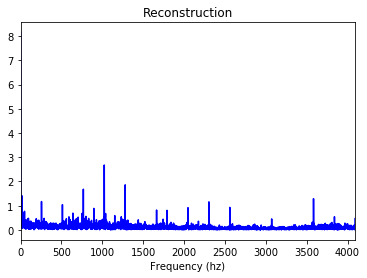

2800 1.0040479021011204


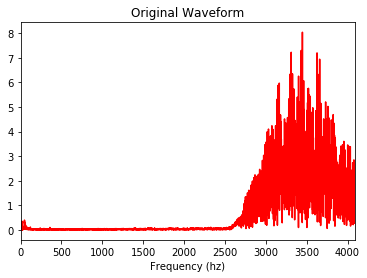

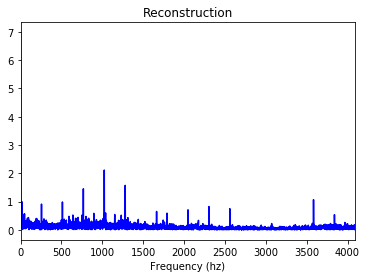

3000 1.0038799567019348


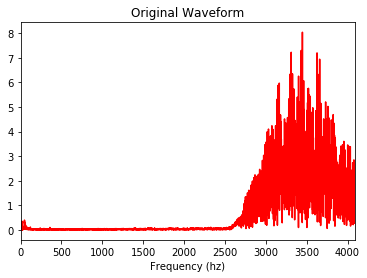

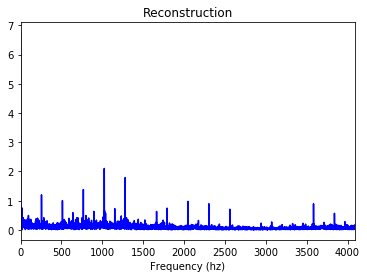

3200 1.0005349145209796


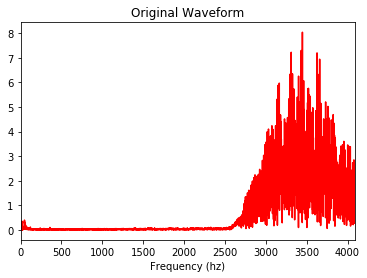

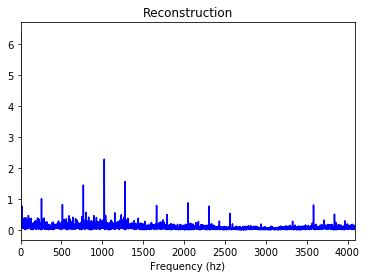

3400 1.013401625351203


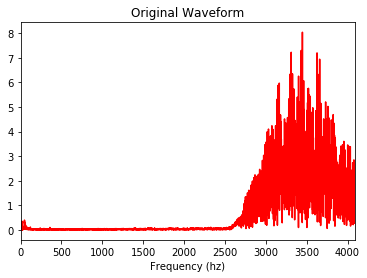

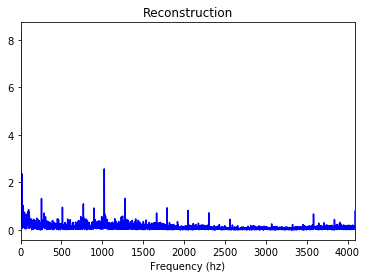

3600 1.0049940382756575


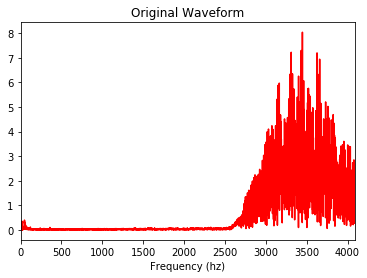

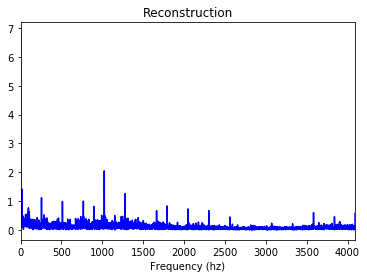

3800 0.9993205426717039


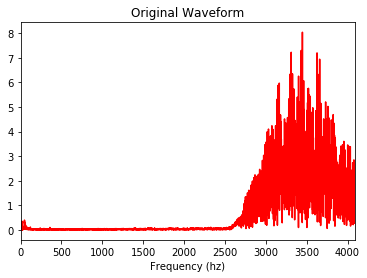

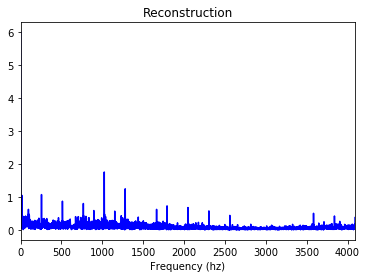

4000 0.9980461441469828


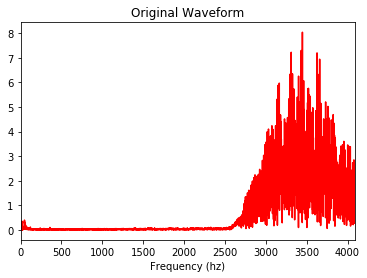

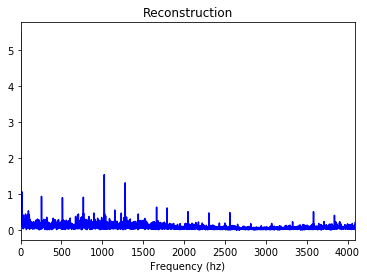

4200 0.9967461767100084


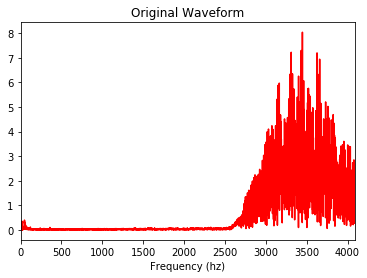

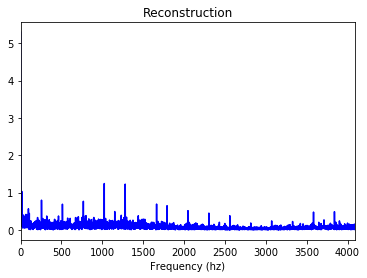

4400 1.00245642439808


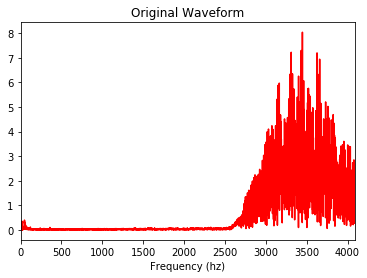

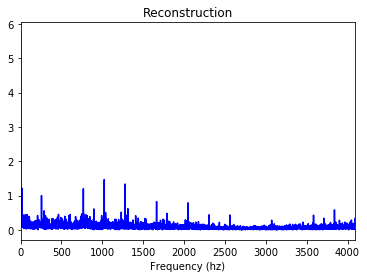

4600 0.9984945993128104


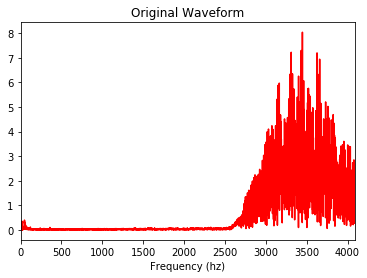

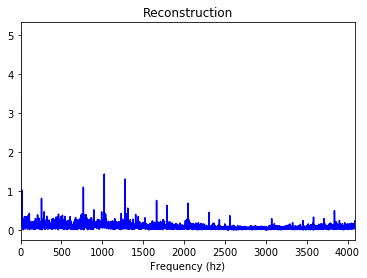

4800 1.0071484127699037


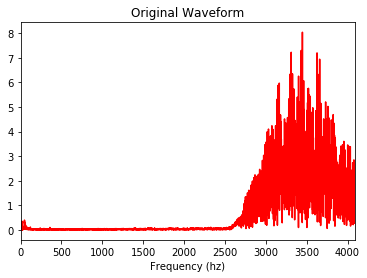

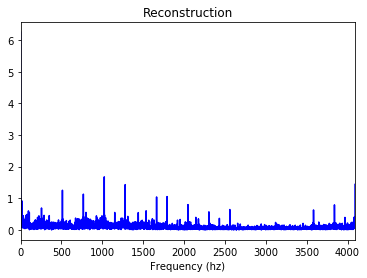

5000 1.000644110061434


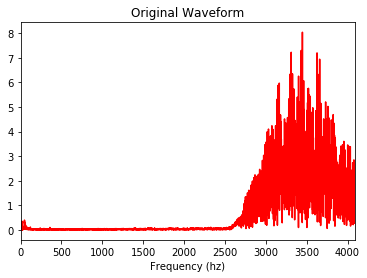

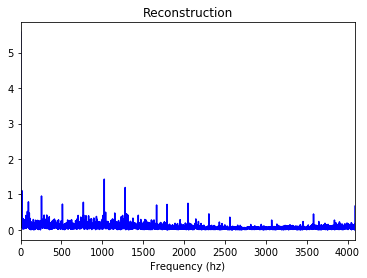

5200 1.0012503277121056


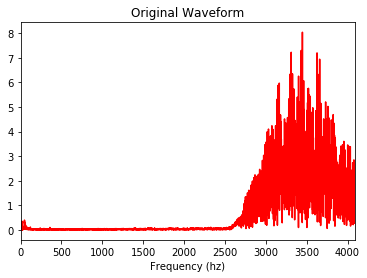

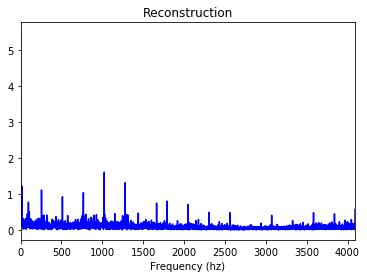

5400 0.9972615126999056


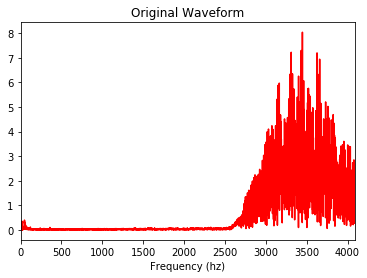

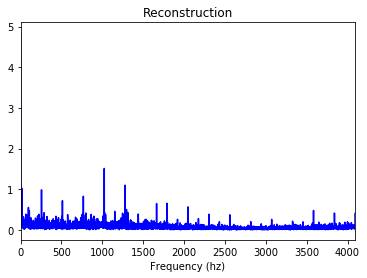

5600 1.014172460101024


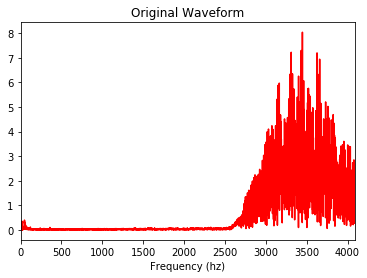

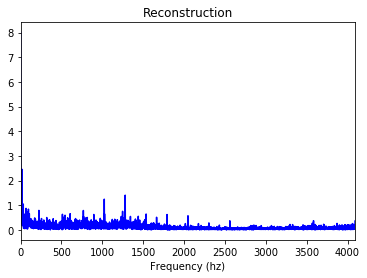

5800 1.005838859953074


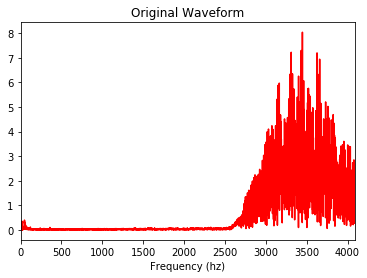

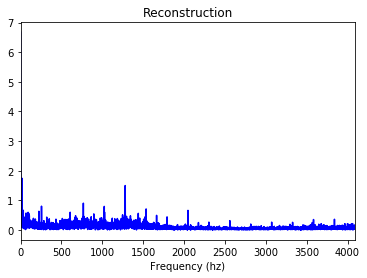

6000 1.0012567976930011


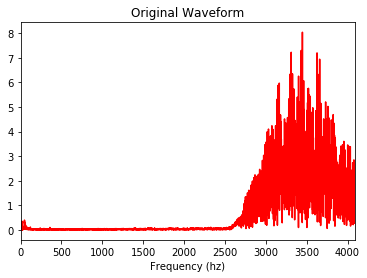

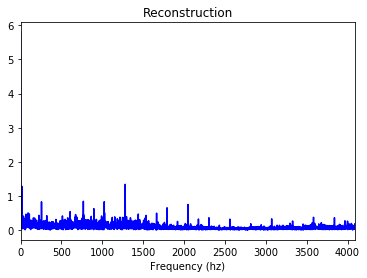

6200 0.9966289265199805


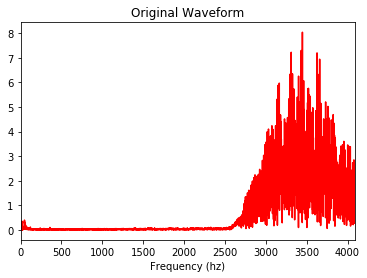

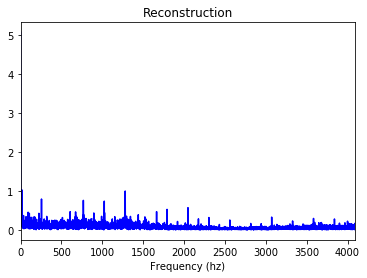

6400 0.9953582730758367


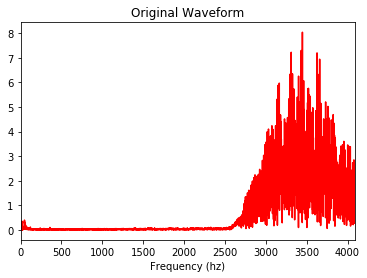

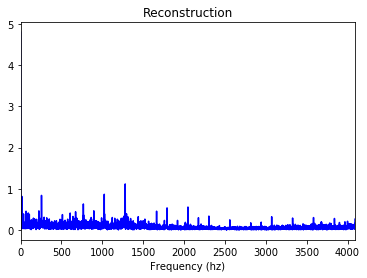

6600 0.9964207790861747


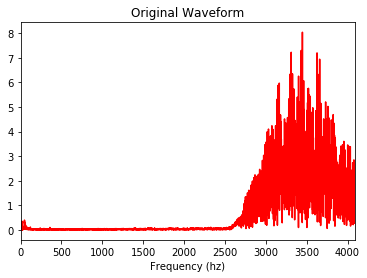

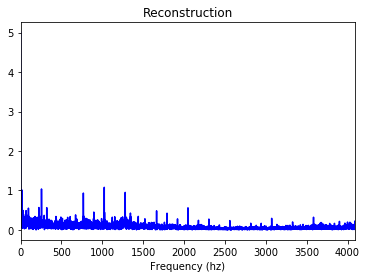

6800 1.0071845133080617


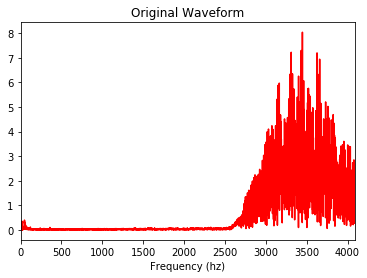

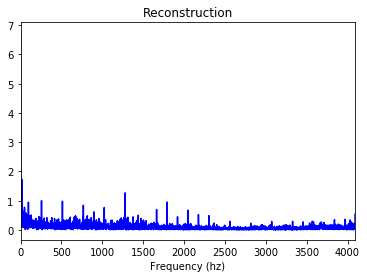

7000 1.0004382167027837


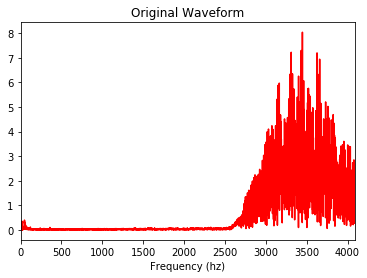

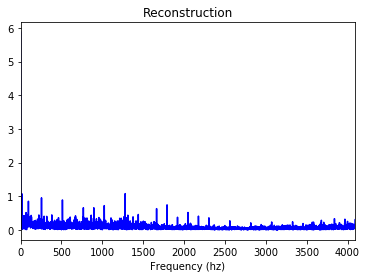

7200 0.9969249842103142


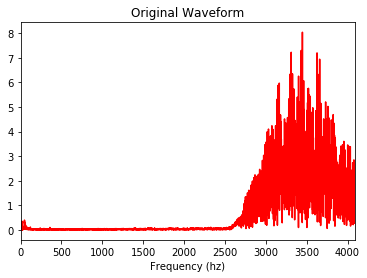

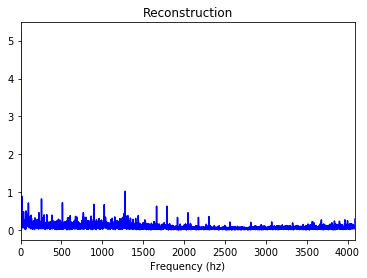

7400 0.9957494450222769


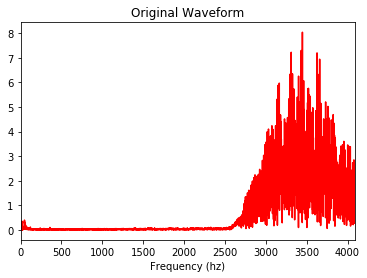

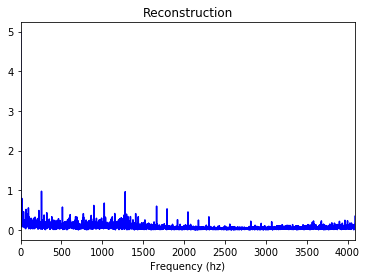

7600 0.9954274420384898


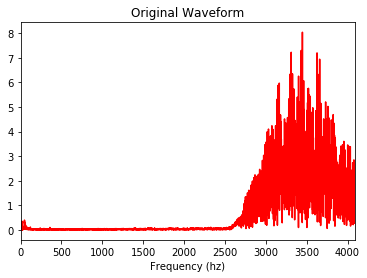

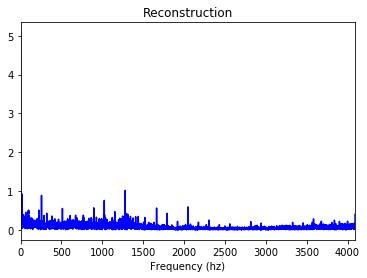

7800 0.9942226485566941


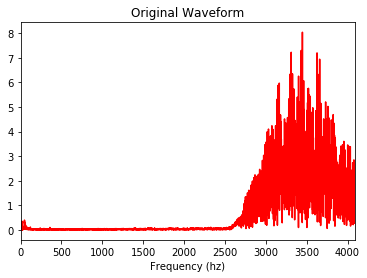

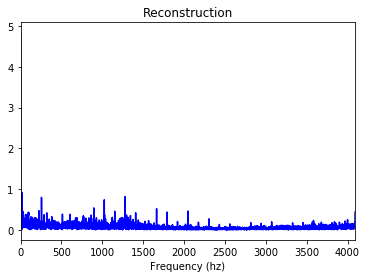

8000 0.9929935833983619


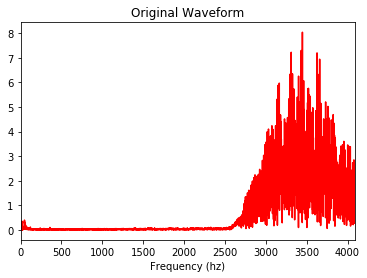

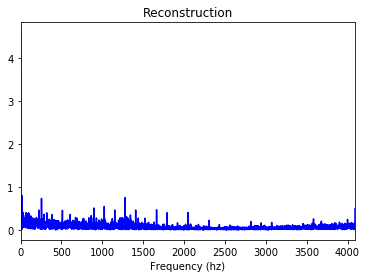

8200 0.9929124813203847


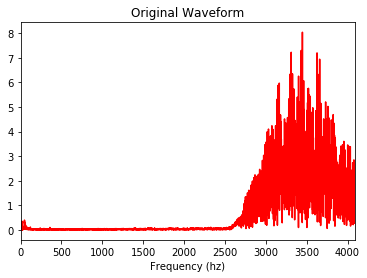

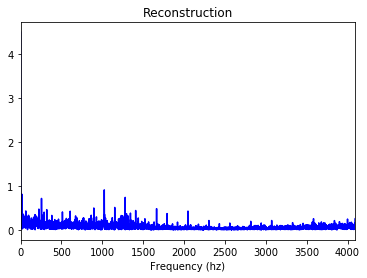

8400 0.9924511618143598


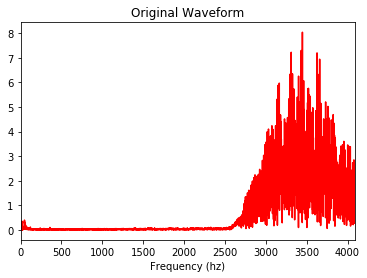

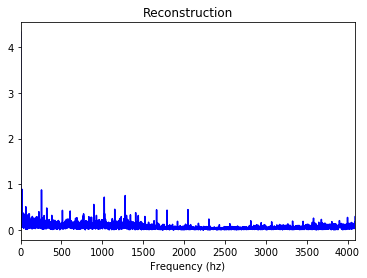

8600 1.0012725010184482


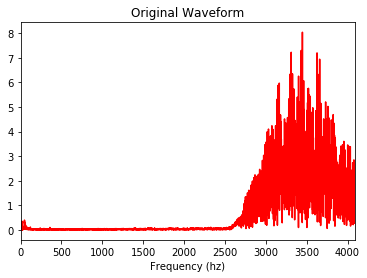

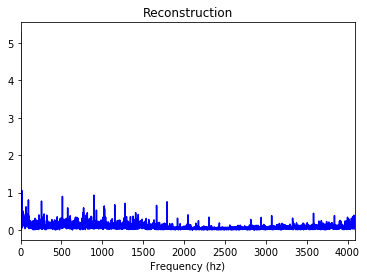

8800 0.9943675170202827


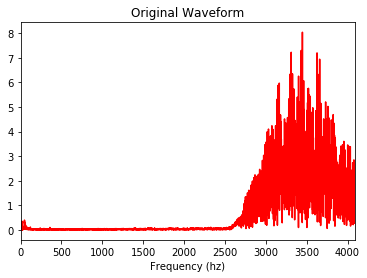

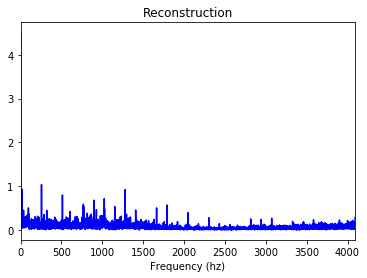

9000 0.9923457362283443


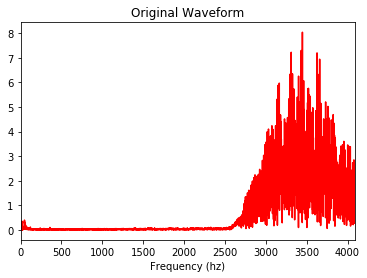

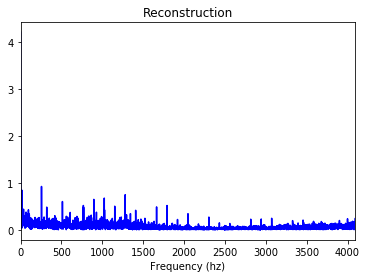

9200 0.9939196608234738


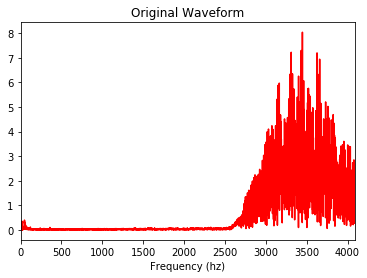

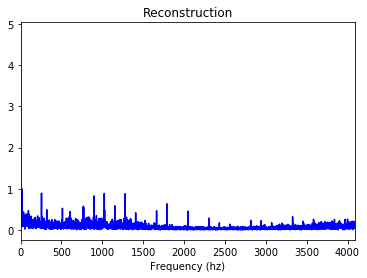

9400 0.9921067142149087


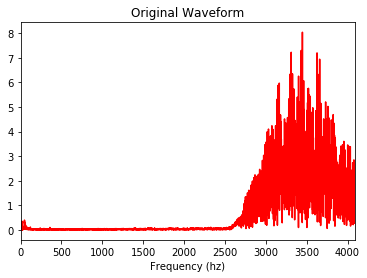

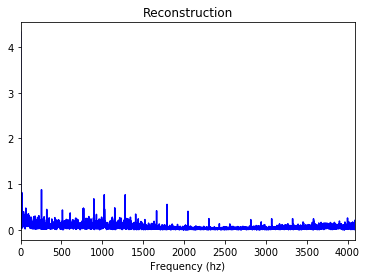

9600 0.9945214768345594


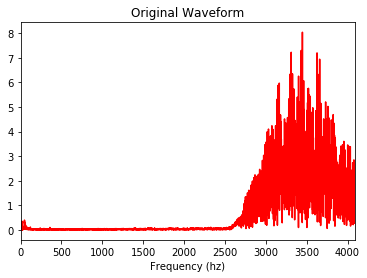

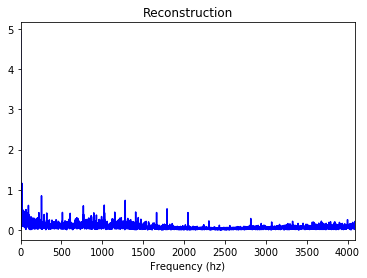

9800 0.9930478861362017


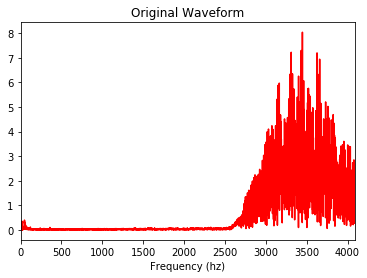

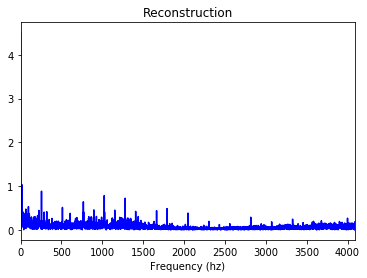

Output MSE:  0.99347
Execution Time:  522.52 s


In [219]:
# Create numpy logs to store images, MSE values (from ground truth) for each iteration
mse_log = np.zeros((NUM_ITER))#, nc))
last_wave = np.zeros((WAVE_LEN, nc))#, nc))
cur_best_mse = 1e6
cur_best_idx = 0

start = time.time()

if scaled:
    y0_transformed = scale(y0, MINS, MAXES)
else:
    y0_transformed = normalise(y0, MU, SIGMA)

for i in range(NUM_ITER):
    optim.zero_grad() # clears graidents of all optimized variables
    out = net(z) # produces wave (in form of data tensor) i.e. G(z,w)
    
    loss = mse(net.measurements(z),measurements) # calculate loss between AG(z,w) and Ay
         
    # DCGAN output is in [-1,1]. Renormalise to [0,1] before plotting
    wave_transformed = out[0].detach().reshape(-1,nc).cpu()
    
    if scaled:
        wave = rescale(wave_transformed, MINS, MAXES)
    else:
        wave = renormalise(wave_transformed, MU, SIGMA)
    
    mse_log[i] = np.mean((np.squeeze(y0) - np.squeeze(wave))**2)/POWER[0]
    
    if (mse_log[i] <= cur_best_mse):
        cur_best_idx = i
        cur_best_mse = mse_log[i]
        
    if (i%200 == 0):
        print(i, mse_log[i])
        
        spectrum =np.fft.fft(y0_transformed[:,0], norm = 'ortho')
        spectrum = abs(spectrum[0:round(len(spectrum)/2)]) # Just first half of the spectrum, as the second is the negative copy

        plt.figure()
        plt.plot(spectrum, 'r')
        plt.xlabel('Frequency (hz)')
        plt.title('Original Waveform')
        #plt.ylim(0, np.max(spectrum))
        plt.xlim(0,WAVE_RATE/2)
        plt.show()
        
        result = np.fft.fft(wave_transformed[:,0], norm = 'ortho')
        result = abs(result[0:round(len(result)/2)])

        plt.figure()
        plt.plot(result, 'b')
        plt.xlabel('Frequency (hz)')
        plt.title('Reconstruction')
        plt.xlim(0, WAVE_RATE/2)
        #plt.ylim(0,np.max(result))
        plt.show()
    
    if(i == NUM_ITER-1):
        last_wave = wave
    
    loss.backward()
    optim.step()
    
#calculate MSE between output wave and non-noisy original; and between noisy and original
True_MSE = mse_log[NUM_ITER-1]
print("Output MSE: ", round(True_MSE, 5))

end = time.time()
print("Execution Time: ", round(end-start, 2), "s")

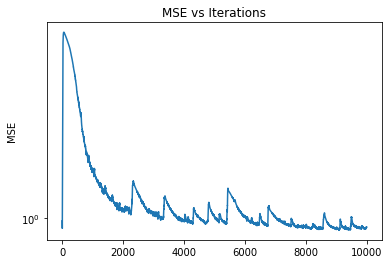

In [220]:
from matplotlib.axes import Axes

itern = np.arange(NUM_ITER)

plt.figure()
plt.ylabel('MSE')
plt.title("MSE vs Iterations")
plt.semilogy(itern, mse_log)

In [221]:
def format_e(n, dec=3, is_hparam = False): 
    a = '%E' % n
    pre = a.split('E')[0].rstrip('0').rstrip('.')
    pre = str(round(float(pre), dec))
    if is_hparam == True:
        pre = str(int(float(pre))) # get rid of decimal
    return pre + 'e' + a.split('E')[1]

print("Last MSE: ", str(format_e(mse_log[-1])))
print("Best MSE: ", str(format_e(cur_best_mse)))
print("Best index: ", cur_best_idx)
wavio.write("Net_best.wav", last_wave, WAVE_RATE, sampwidth=WAVE_RES)

Last MSE:  9.935e-01
Best MSE:  9.915e-01
Best index:  9465


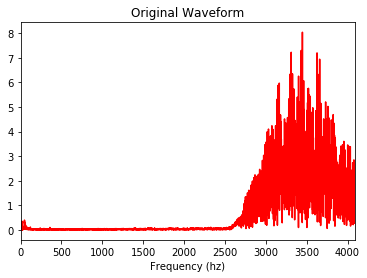

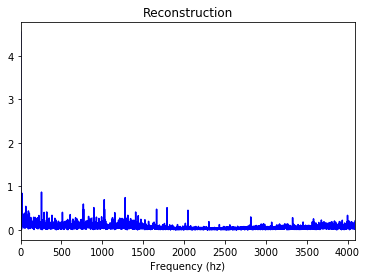

In [222]:
spectrum =np.fft.fft(y0_transformed[:,0], norm = 'ortho')
spectrum = abs(spectrum[0:round(len(spectrum)/2)]) # Just first half of the spectrum, as the second is the negative copy

plt.figure()
plt.plot(spectrum, 'r')
plt.xlabel('Frequency (hz)')
plt.title('Original Waveform')
plt.xlim(0,WAVE_RATE/2)
plt.show()

if scaled:
    result = np.fft.fft(scale(last_wave, MINS, MAXES)[:,0], norm = 'ortho')
else:
    result = np.fft.fft(normalise(last_wave, MU, SIGMA)[:,0], norm = 'ortho')
result = abs(result[0:round(len(result)/2)])

plt.figure()
plt.plot(result, 'b')
plt.xlabel('Frequency (hz)')
plt.title('Reconstruction')
plt.xlim(0, WAVE_RATE/2)
plt.show()